In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle

In [2]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.chdir('/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/')

In [5]:
data=pd.read_pickle('final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [6]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:21<00:00,  1.92s/it]


In [7]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [8]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [9]:
data.drop(['date'],axis=1,inplace=True)

In [10]:
X_train, y_train = data[data['d']<1914].drop('demand',axis=1), data[data['d']<1914]['demand']
X_valid, y_valid = data[(data['d']>=1914) & (data['d']<1942)].drop('demand',axis=1), data[(data['d']>=1914) & (data['d']<1942)]['demand']
X_test = data[data['d']>=1942].drop('demand',axis=1)

In [11]:
def rmse(pred,value):
    return np.sqrt(((pred-value)**2).mean())

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [13]:
def Time_series_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape = (input_shape,1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=25))
    model.add(Dense(1, activation='linear'))
    return model

In [14]:
model = Time_series_model(X_train.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 81, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 81, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 81, 100)           100400    
                                                                 
 dropout_1 (Dropout)         (None, 81, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 81, 50)            30200     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 2

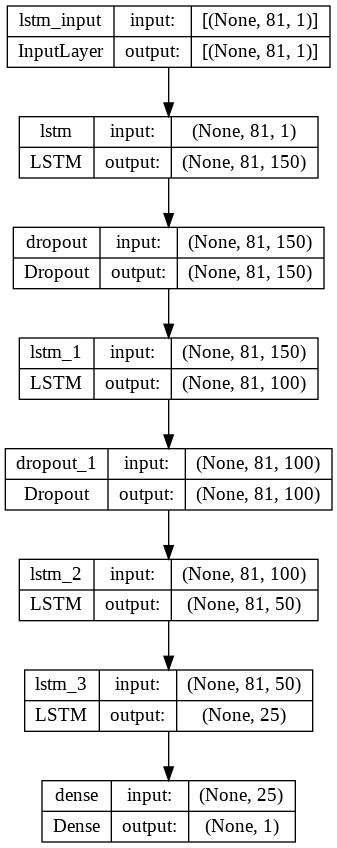

In [15]:
plot_model(model, show_shapes=True)

In [ ]:
from tensorflow import keras
filepath="weights.best.hdf1"
model = keras.models.load_model(filepath)

In [ ]:
from tensorflow.keras.callbacks import *
import os
import datetime
filepath="weights.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_root_mean_squared_error',  mode="min",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_root_mean_squared_error', factor = 0.25, patience = 1, verbose = 1,min_lr=0.000001)
callbacks = [reduce_lr,earlystop]

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(x=X_train, y=y_train,epochs=50,verbose=1,batch_size=256, validation_data=(X_valid, y_valid), callbacks=callbacks)

2022-11-15 07:21:01.864930: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4180666840 exceeds 10% of free system memory.
2022-11-15 07:21:06.140065: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4180666840 exceeds 10% of free system memory.


Epoch 1/50
49189/49189 [==============================] - 1130s 23ms/step - loss: 0.0529 - root_mean_squared_error: 0.2300 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1344 - lr: 0.0010
Epoch 2/50
49189/49189 [==============================] - 1081s 22ms/step - loss: 0.0470 - root_mean_squared_error: 0.2168 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1276 - lr: 0.0010
Epoch 3/50
49188/49189 [============================>.] - ETA: 0s - loss: 0.0402 - root_mean_squared_error: 0.2004
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
49189/49189 [==============================] - 1079s 22ms/step - loss: 0.0402 - root_mean_squared_error: 0.2004 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1444 - lr: 0.0010
Epoch 4/50
49189/49189 [==============================] - 1083s 22ms/step - loss: 0.0182 - root_mean_squared_error: 0.1350 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710 - lr: 2.5000e-04
Epoch 5/50
49189/49189 [====================

In [ ]:
filepath="weights.best.hdf1"
model.save(filepath)

INFO:tensorflow:Assets written to: weights.best.hdf1/assets


INFO:tensorflow:Assets written to: weights.best.hdf1/assets


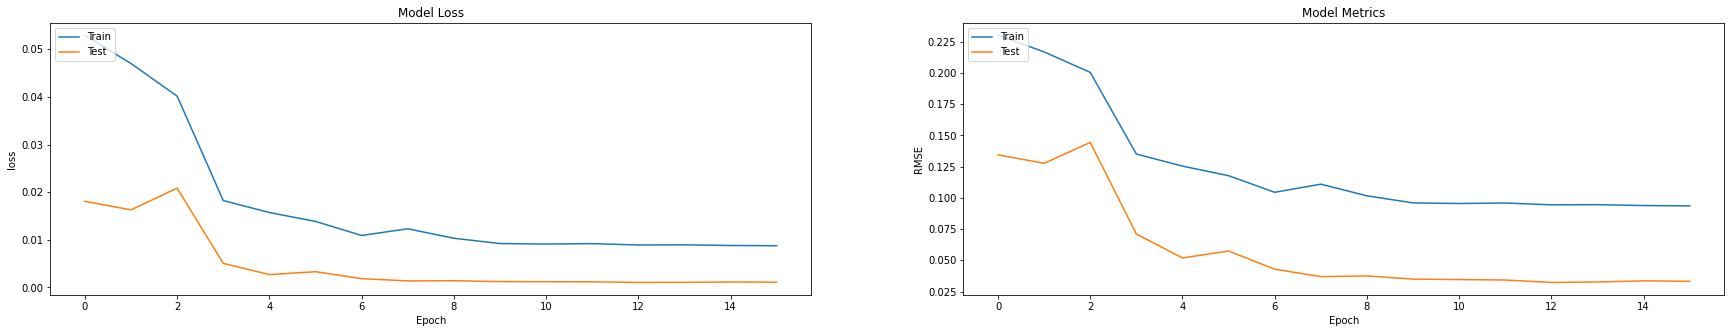

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()